In [3]:
# !pip install deepxde

In [5]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

dde.backend.backend_name = "pytorch"

For a single variable function, **Jacobian** (1st order derivative) and **Hessian** (2nd order derivative) are scalar. For a multivariate function **Jacobian** is a **vector** and **Hessian** is a **matrix**.

In [6]:
# defining governing Differential equation d^2u/dx^2 = 2, x E [-1,1]
def pde(x,y):
  dy_xx = dde.grad.hessian(y,x)
  return dy_xx - 2

# Dirchlet boundary condition on the left boundary

In [7]:
# Left BCs
def boundary_value_l(X):
  return 0

def boundary_l(x, on_boundary):
  return on_boundary and dde.utils.isclose(x[0], -1)

# Neumann coundary condition on the right boundary

In [8]:
# Right BCs
def boundary_flux_r(X):
  return 4 #Sets (du/dx) = 4 at all x=1

def boundary_r(x, on_boundary):
  return on_boundary and dde.utils.isclose(x[0], 1)

In [9]:
geom = dde.geometry.Interval(-1,1)

In [10]:
bc_l = dde.icbc.DirichletBC(geom, boundary_value_l, boundary_l)

In [11]:
bc_r = dde.icbc.NeumannBC(geom, lambda X: 2*(X+1), boundary_r)

In [12]:
#Exact solution
def func(x):
  return (x+1)**2

In [13]:
#16 are the number of collocation points and 2 are the boundary conditions
data = dde.data.PDE(geom, pde, [bc_l, bc_r], 16, 2, solution =func, num_test=100)

In [14]:
#The Neural network
layer_size = [1] + [50]*3 + [1] #[input] + [no. of nodes]*hidden_layers + [output]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer) #FNN = Fully-connected Neural Net

In [15]:
#Model Training
model = dde.Model(data, net)
model.compile("adam", lr = 0.001, metrics = ["l2 relative error"])
losshistory, train_state = model.train(epochs = 10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.126854 s

'compile' took 0.607212 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.02e+00, 2.70e-02, 1.71e+01]    [4.00e+00, 2.70e-02, 1.71e+01]    [1.04e+00]    
1000      [3.78e-04, 1.33e-08, 7.97e-08]    [2.82e-04, 1.33e-08, 7.97e-08]    [1.09e-03]    
2000      [5.74e-05, 9.27e-06, 3.59e-06]    [3.66e-05, 9.27e-06, 3.59e-06]    [8.87e-04]    
3000      [2.88e-05, 1.00e-08, 9.84e-09]    [2.31e-05, 1.00e-08, 9.84e-09]    [2.63e-04]    
4000      [2.46e-05, 2.34e-05, 1.19e-05]    [2.07e-05, 2.34e-05, 1.19e-05]    [1.47e-03]    
5000      [1.99e-05, 2.38e-10, 3.11e-10]    [1.88e-05, 2.38e-10, 3.11e-10]    [3.53e-04]    
6000      [1.76e-05, 4.36e-06, 2.48e-06]    [1.69e-05, 4.36e-06, 2.48e-06]    [6.29e-04]    
7000      [1.35e-05, 1.42e-09, 7.39e-10]    [1.34e-05, 1.42e-09, 7.39e-10]    [3.41e-04]    
8000      [1.00e-05, 6.84e-11, 7.

Above in the Train Loss: [a,b,c] -> a is pde loss, b is Dirchlet BC loss, c is Neumann BC loss

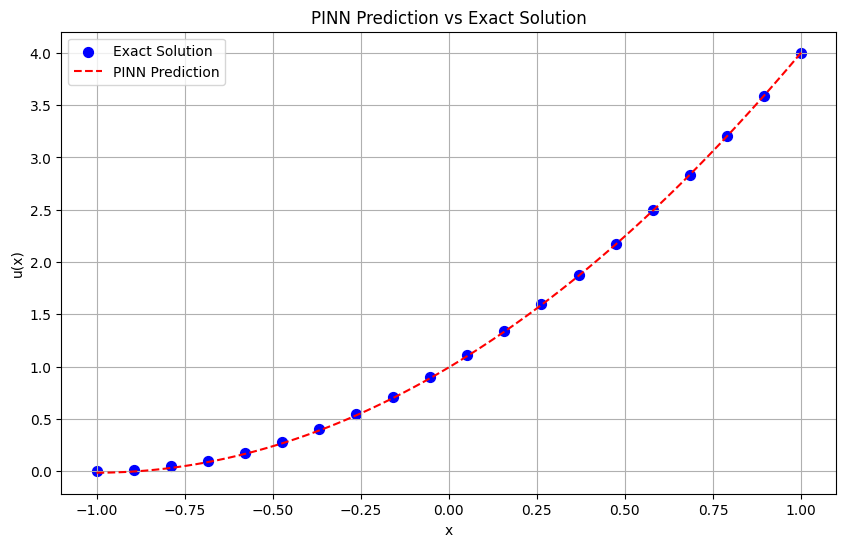

In [16]:
# Generate a range of x values within the domain
x_values_pinn = np.linspace(-1,1,100).reshape(-1,1)
x_values_exact = np.linspace(-1,1,20).reshape(-1, 1)

#Use the trained model to predict the output for x values
y_pred = model.predict(x_values_pinn)

#Compute the exact solution for the same x_values
y_exact  = func(x_values_exact)

#Plot the PINN prediction vs the exact solution
plt.figure(figsize=(10,6))
#Scatter plot for the exact solution
plt.scatter(x_values_exact, y_exact, label='Exact Solution', color = 'blue', marker= 'o', s=50)

#Line plot for the PINN predictions
plt.plot(x_values_pinn, y_pred, label='PINN Prediction', color = 'red', linestyle='--')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('PINN Prediction vs Exact Solution')
plt.legend()
plt.grid(True)
plt.show()